# March Madness Bracket Predictor

### The objective of this project is to use machine learning models in order to predict the outcomes of March Madness games, then using these predictions to generate a bracket. 

*This project is a work in progress. The initial goal is to get a minimum working example and then progressively improve the results via data exploration, additional models, further hyperparameter tuning, etc.*

## Outline:
1. Problem Definition
2. Data Explaination
3. Evaluation
4. Feature Selection
5. Modeling
6. Results and Summary

## 1. Problem Definition
March Madness is the post season, 64-team bracket for (Men's) NCAA Basketball. The winner of the tournament is deemed the national champion. It is common practice to individually fill out these brackets prior to the start of the first game. The objective of this project is to predict the outcome of a game between two selected teams, this infomation will then be used to generate an entire bracket of predictions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Basic imports, they were added as needed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb

from feature_vector_prep import matchup_generator

## 2. Data Explanation
This project is currently using data from [RealGM](https://basketball.realgm.com/ncaa/team-stats/2022/Totals/Team_Totals/0). The data contains numerous statistics of each team from the year 02-03 until 21-22 (excluding 19-20 and 20-21 due to COVID irregularities). These statistics include:
* seed = Seed in the NCAA tournament
* wins = Number of wins
* losses = Number of losses
* winp = Win percentage
* cwins = Number of conference wins
* closses = Number of conference losses
* cwinp = Conference win percentage
* pts = Number of points scored
* ptspg = Points per game
* fgm = Number of field goals made
* fga = Number of field goals attempted
* fgp = Field goal percentage
* 3pm = Number of 3 pointers made
* 3pa = Number of 3 pointers attempted
* 3pp = 3 pointer percentage 
* ftm = Number of free throws made
* fta = Number of free throws attempted
* ftp = Free throw percentage
* orb = Number of offensive rebounds
* orbpg = Offensive rebounds per game
* drb = Number of defensive rebounds
* drbpg = Defensive rebounds per game
* reb = Number of rebounds
* rebpg = Rebounds per game
* ast = Number of assists
* astpg = Assists per game
* stl = Number of steals
* stlpg = Steals per game
* blk = Number of blocks
* blkpg = Blocks per game
* tov = Number of turnovers
* tovpg = Turnovers per game
* pf = Number of personal fouls
* pfpg = Personal fouls per game

We will utilize the above attributes to represent each team. For each game, we represent the winner by their stat vector $W = \langle \text{seed, wins, losses,} \dots \text{, pf, pfpg}\rangle$. We represent the loser, $L$ in a similar fashion. Each game is then morphed into two feature vectors: $\langle W - L, 1 \rangle$ and $\langle L - W, 0 \rangle$ to properly account for substraction not being a commutative operation.

In [3]:
# load the feature vector dataframe
df = pd.read_csv("feature-vectors.csv")
df = df.dropna()
all_stats = pd.read_csv("all_stats.csv")
all_stats = all_stats.dropna()

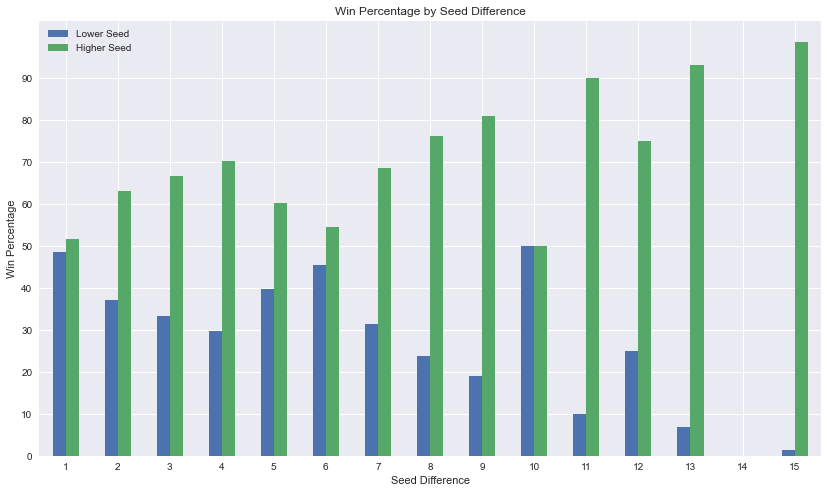

In [4]:
seeds = pd.DataFrame()
seed_df = df[df["result"] == 1]["seed"]
counts = seed_df.value_counts()
for i in range(1, 16):
    total_seeds = counts.get(i, 0) + counts.get(-1*i, 0)
    if total_seeds != 0:
        seeds[i] = [counts.get(-1*i, 0)/total_seeds, counts.get(i, 0)/total_seeds]
    else:
        seeds[i] = [0, 0]
seeds = (seeds.round(3))*100

seeds.T.plot.bar(figsize=(14,8))
plt.title("Win Percentage by Seed Difference")
plt.legend(["Lower Seed", "Higher Seed"])
plt.xlabel("Seed Difference")
plt.xticks(rotation = 0)
plt.ylabel("Win Percentage")
plt.yticks(np.arange(0, 100, 10));

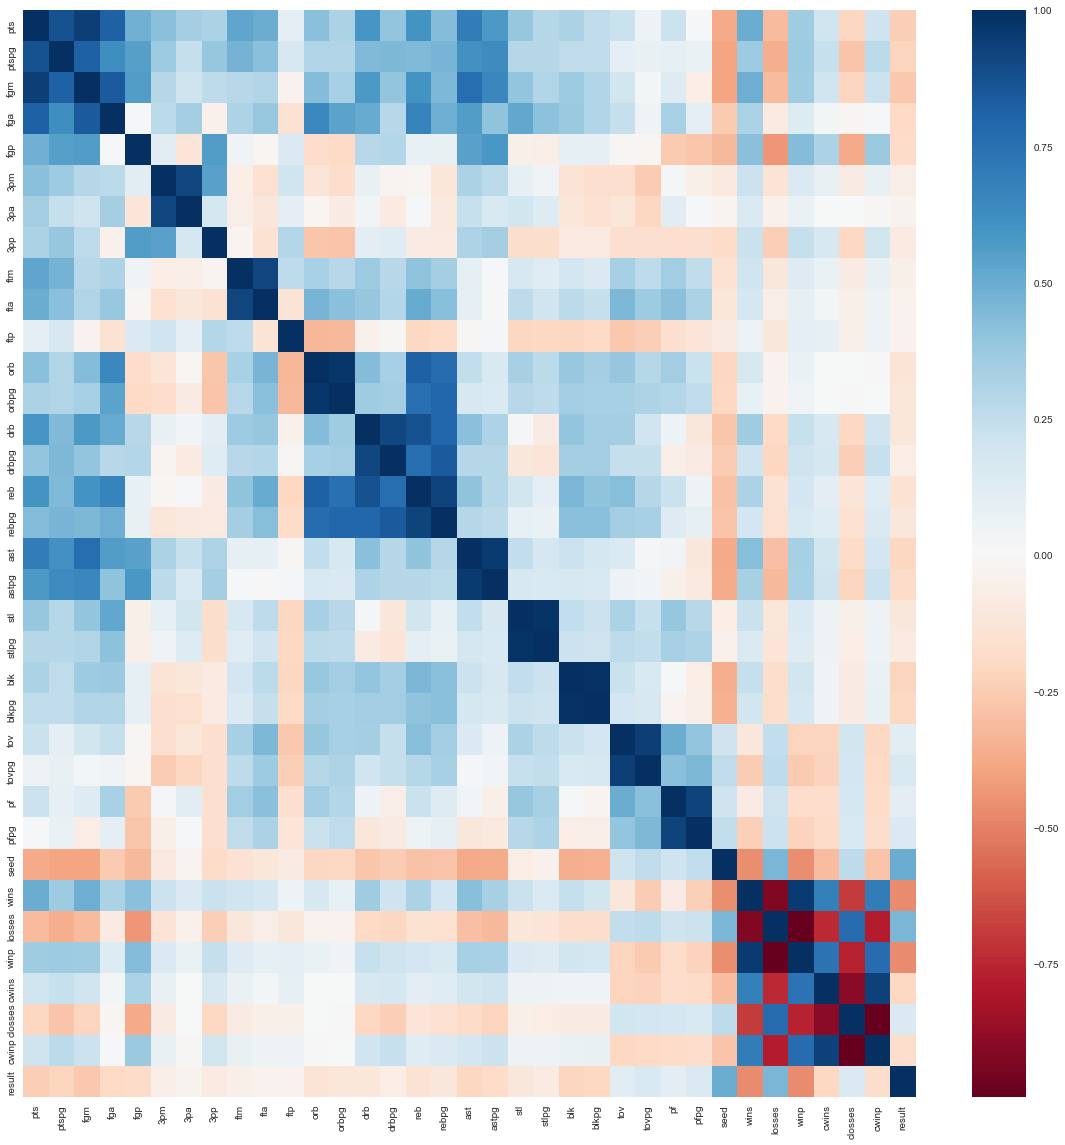

In [5]:
plt.figure(figsize=(20,20))
corr_matrix = df.drop("year", axis=1).corr()
sns.heatmap(corr_matrix, annot=False, cmap="RdBu");

In [6]:
cols_to_drop = ['team0', 'team1',
             'losses', 'winp', 'cwins',
             'closses', 'pts', 'fgm',
             'fga', '3pm', '3pa',
             'ftm', 'fta', 'orb',
             'orbpg', 'drb', 'drbpg',
             'reb', 'ast', 'stl',
             'blk', 'tov', 'pf']

feature_vectors = df.drop(cols_to_drop, axis=1)
feature_vectors

,ptspg,fgp,3pp,ftp,rebpg,astpg,stlpg,blkpg,tovpg,pfpg,seed,wins,cwinp,year,result
0,6.046,0.036,0.010,0.007,3.921,2.886,-0.795,3.370,-1.728,-2.018,-15.0,7.0,0.286,2003.0,0.0
1,-6.046,-0.036,-0.010,-0.007,-3.921,-2.886,0.795,-3.370,1.728,2.018,15.0,-7.0,-0.286,2003.0,1.0
2,15.219,0.002,0.008,0.070,2.479,4.211,3.225,-1.025,2.738,1.034,-1.0,-3.0,-0.230,2003.0,1.0
3,-15.219,-0.002,-0.008,-0.070,-2.479,-4.211,-3.225,1.025,-2.738,-1.034,1.0,3.0,0.230,2003.0,0.0
4,-3.824,-0.008,0.029,-0.002,-1.069,-0.918,0.323,2.054,-2.165,-3.914,-7.0,-4.0,-0.250,2003.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2261,-2.661,-0.036,-0.006,0.043,1.361,-2.094,-1.047,-1.681,1.432,0.717,6.0,0.0,-0.050,2022.0,0.0
2262,5.952,0.044,-0.004,-0.099,2.335,3.380,0.170,1.905,2.529,0.611,-1.0,2.0,-0.022,2022.0,0.0
2263,-5.952,-0.044,0.004,0.099,-2.335,-3.380,-0.170,-1.905,-2.529,-0.611,1.0,-2.0,0.022,2022.0,1.0
2264,1.073,0.028,-0.007,-0.048,-2.302,0.623,0.988,0.299,0.862,1.489,-7.0,1.0,0.028,2022.0,0.0


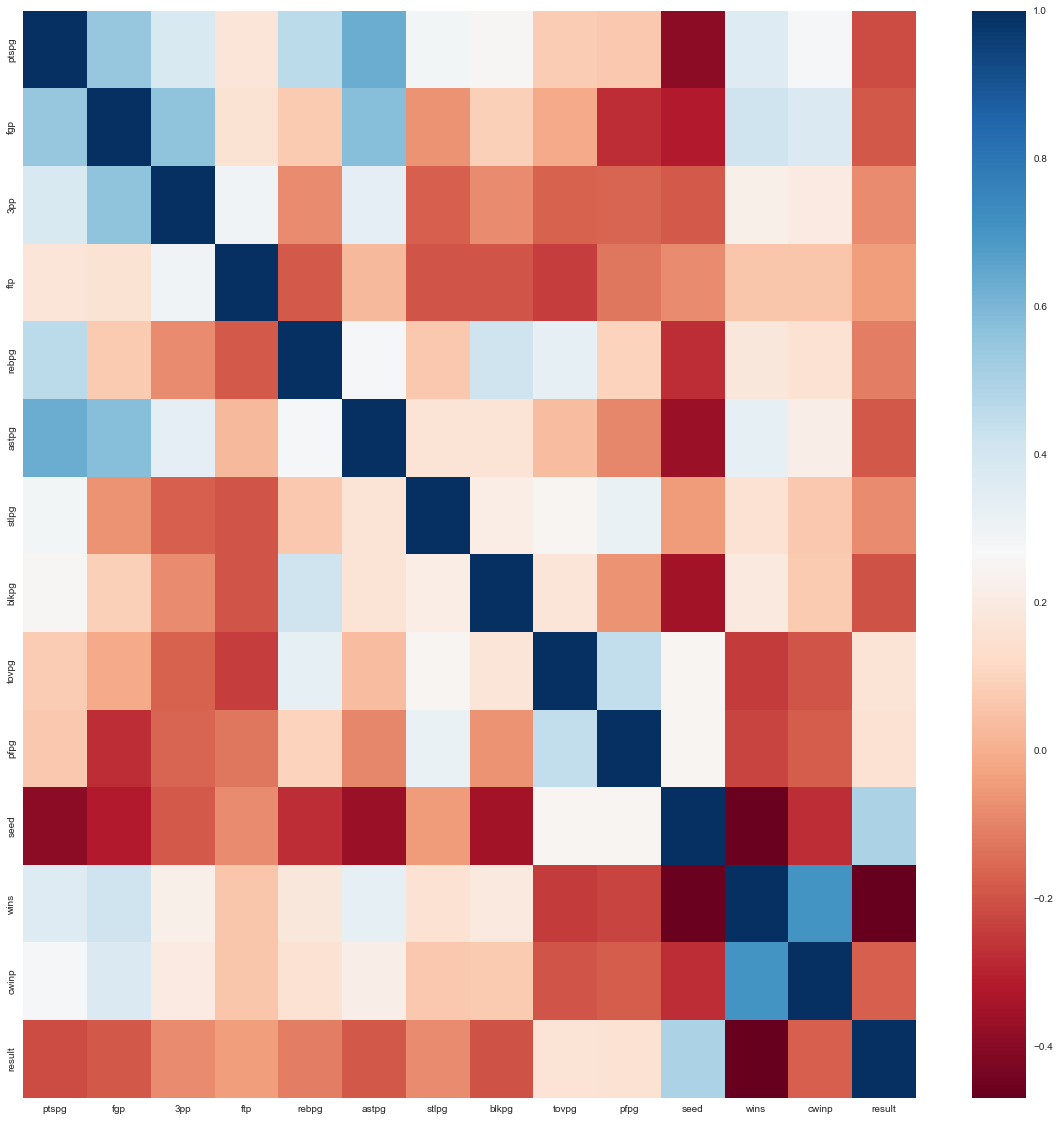

In [7]:
plt.figure(figsize=(20,20))
corr_matrix = feature_vectors.drop("year", axis=1).corr()
sns.heatmap(corr_matrix, annot=False, cmap="RdBu");

In [8]:
df_train = feature_vectors[feature_vectors["year"] < 2022]
df_train = df_train.drop("year", axis=1)
df_train = df_train.sample(frac=1)

In [9]:
X_train = df_train.drop("result", axis=1)
y_train = df_train["result"]

In [10]:
X_train

,ptspg,fgp,3pp,ftp,rebpg,astpg,stlpg,blkpg,tovpg,pfpg,seed,wins,cwinp
1651,-7.068,-0.033,-0.048,-0.113,-5.188,-7.498,1.800,-1.632,0.297,1.276,13.0,-3.0,0.000
2078,3.333,-0.018,0.011,-0.056,3.074,-0.611,1.709,2.294,2.273,2.003,-7.0,-7.0,-0.319
150,0.482,-0.001,0.002,0.051,4.448,-0.345,-4.862,1.379,0.724,-0.793,-5.0,-1.0,0.000
996,6.877,-0.006,0.063,0.037,5.699,-0.090,-0.024,-0.263,0.046,-0.188,-3.0,2.0,0.034
70,3.931,0.018,-0.019,-0.093,-2.620,1.104,-0.862,3.379,-0.552,-5.345,-11.0,3.0,0.034
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1466,6.678,0.011,-0.026,-0.048,2.997,3.037,-0.033,-2.175,0.074,1.482,-5.0,-3.0,0.222
1358,6.297,0.013,0.013,0.037,-2.947,1.366,0.614,-2.043,-2.752,-2.649,-5.0,3.0,0.278
259,-3.465,-0.015,0.012,-0.051,1.429,-3.000,0.679,-0.893,2.500,4.786,9.0,-3.0,0.117
299,-13.898,0.017,-0.006,0.010,-16.344,-4.065,-3.272,0.647,-0.607,-6.114,7.0,0.0,0.222


In [19]:
df_bracket = pd.read_csv("brackets/2022-bracket.csv")
df_bracket = df_bracket[df_bracket["round"] == 1]
df_bracket = df_bracket.drop(["region", "round", "winner"], axis=1)
df_bracket
for i, game in df_bracket.iterrows():
    print(game.year, game.team0, game.team1)

2022 Gonzaga Georgia State
2022 Boise State Memphis
2022 Connecticut New Mexico State
2022 Arkansas Vermont
2022 Alabama Notre Dame
2022 Texas Tech Montana State
2022 Michigan State Davidson
2022 Duke Cal State Fullerton
2022 Baylor Norfolk State
2022 North Carolina Marquette
2022 Saint Mary's Indiana
2022 UCLA Akron
2022 Texas Virginia Tech
2022 Purdue Yale
2022 Murray State San Francisco
2022 Kentucky Saint Peter's
2022 Arizona Wright State
2022 Seton Hall Texas Christian
2022 Houston UAB
2022 Illinois Chattanooga
2022 Colorado State Michigan
2022 Tennessee Longwood
2022 Ohio State Loyola (IL)
2022 Villanova Delaware
2022 Kansas Texas Southern
2022 San Diego State Creighton
2022 Iowa Richmond
2022 Providence South Dakota State
2022 LSU Iowa State
2022 Wisconsin Colgate
2022 USC Miami (FL)
2022 Auburn Jacksonville State


In [ ]:
curr_bracket = 

In [15]:
df_test = feature_vectors[feature_vectors["year"] >= 2022]
df_test = df_test.drop("year", axis=1)
df_test = df_test.sample(frac=1)

In [16]:
X_test = df_test.drop("result", axis=1)
y_test = df_test["result"]

In [47]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
with open("model.pkl", "wb") as f:
    pickle.dump(clf, f)

In [48]:
clf.score(X_test, y_test)

0.7301587301587301

In [49]:
blarg.drop(cols_to_drop, axis=1)

,ptspg,fgp,3pp,ftp,rebpg,astpg,stlpg,blkpg,tovpg,pfpg,seed,wins,cwinp,year,result
0,2.242,0.024,-0.001,0.077,-9.969,-0.152,3.606,-1.546,-2.424,-0.667,3.0,0.0,0.0,2022.0,0
1,-2.242,-0.024,0.001,-0.077,9.969,0.152,-3.606,1.546,2.424,0.667,-3.0,0.0,0.0,2022.0,1


In [50]:
blarg

,pts,ptspg,fgm,fga,fgp,3pm,3pa,3pp,ftm,fta,...,wins,losses,winp,cwins,closses,cwinp,year,team0,team1,result
0,74.0,2.242,24.0,-49.0,0.024,20.0,59.0,-0.001,6.0,-55.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2022.0,Miami (FL),USC,0
1,-74.0,-2.242,-24.0,49.0,-0.024,-20.0,-59.0,0.001,-6.0,55.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2022.0,USC,Miami (FL),1


In [51]:

blarg

,pts,ptspg,fgm,fga,fgp,3pm,3pa,3pp,ftm,fta,...,wins,losses,winp,cwins,closses,cwinp,year,team0,team1,result
0,74.0,2.242,24.0,-49.0,0.024,20.0,59.0,-0.001,6.0,-55.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2022.0,Miami (FL),USC,0
1,-74.0,-2.242,-24.0,49.0,-0.024,-20.0,-59.0,0.001,-6.0,55.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2022.0,USC,Miami (FL),1


In [64]:
a = matchup_generator(all_stats, 2022, "Miami (FL)", "USC", winner=0)
blarg = pd.DataFrame(a)
display(blarg)
b = blarg.drop(cols_to_drop + ["year", "result"], axis=1)
display(b)
clf.predict_proba(b)

,pts,ptspg,fgm,fga,fgp,3pm,3pa,3pp,ftm,fta,...,wins,losses,winp,cwins,closses,cwinp,year,team0,team1,result
0,74.0,2.242,24.0,-49.0,0.024,20.0,59.0,-0.001,6.0,-55.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2022.0,Miami (FL),USC,0
1,-74.0,-2.242,-24.0,49.0,-0.024,-20.0,-59.0,0.001,-6.0,55.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2022.0,USC,Miami (FL),1


,ptspg,fgp,3pp,ftp,rebpg,astpg,stlpg,blkpg,tovpg,pfpg,seed,wins,cwinp
0,2.242,0.024,-0.001,0.077,-9.969,-0.152,3.606,-1.546,-2.424,-0.667,3.0,0.0,0.0
1,-2.242,-0.024,0.001,-0.077,9.969,0.152,-3.606,1.546,2.424,0.667,-3.0,0.0,0.0


array([[0.48294447, 0.51705553],
       [0.51705553, 0.48294447]])

In [53]:
y_preds = clf.predict(X_test)
y_preds

array([1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
       1., 1., 0., 0., 1., 1., 1.])

In [ ]:
df_test["preds"] = y_preds
a = df_test[df_test["preds"] != df_test["result"]].index

In [ ]:
df.loc[a].head(50)

In [ ]:
blah = pd.read_csv(f"brackets/2022-bracket.csv")
b = blah[blah["year"] == 2022]
b = blah[blah["round"] == 1.0]
b = b[["year", "team0", "team1", "region"]]
b
b.to_csv("test-input.csv", index=False)

In [ ]:
r = results.iloc[::2]
r.head(50)

In [ ]:
results = df[df["year"] == 2022]
results = results[["team0", "team1", "result"]]
results["pred"] = y_preds
results[results["result"] != results["pred"]]

In [ ]:
df_test

In [ ]:
X_test.head()

In [ ]:
y_test.head()

In [ ]:
test = X_test
test["result"] = y_test
test["pred"] = y_preds

In [ ]:
test

In [ ]:
y_preds != y_test

In [ ]:
mismatch = []
for pred, label in zip(y_preds, y_test):
    if pred != label:
        mismatch.append(y_preds[pred].index)
        
mismatch

In [ ]:
a = (y_preds != y_test)
a

In [ ]:
a[a]

In [ ]:
a = list(a[a].index)
a = a[::2]

In [ ]:
df

In [ ]:
df.loc[a]